##GENDER INCOME GAP

You may know that it is estimated that women earn about 78% of men in the same job position. 
Can we test that on NYC income data? Can we turn that into a prediction: if you get hired at a certain stipend as a men, what should you expect to make as a woman? (or from the point of view of a job employer, perhaps not one with a very strong moral compass, what should I offer a woman job candidate, given what I would offer a man for the same job?)




In [1]:
import pandas as pd
import sys
import os
import numpy as np
import pylab as pl
import statsmodels.api as sm
import json
import os
s = json.load( open(os.getenv('PUI2015')+"/ylai_matplotlibrc.json") )
pl.rcParams.update(s)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/ericlaibuffalo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#The gender gap(non mandatory viewing)
from IPython.display import YouTubeVideo
YouTubeVideo("G_ikzQM93W8")

the Census data on income
http://www.census.gov/hhes/www/cpstables/032015/perinc/pinc03_000.htm

unfortunately a lot of the links that i originally used a few weeks ago are broken now. I posted the data I had used on the class webpage here (together with data for the buildings & energy homework): http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data

In [3]:
#to use the url just pas it to pandas read_excell
url="http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/"
#split your data by male and female, for example you can load the data into 2 dictionary. other variables may be relevant: for example race.
#the names are not informative, and I am not giving you any meta data to find out what is in each file. 
# 08_2 files are male, 08_3 are female, and I am leaving in the lines of code that read the male files into races

allmales={}
allfemales={}
allmales['all']=pd.read_excel(url+'/pinc08_2_1_1.xls',header=9)#%s/pinc03_2_1_1.xls'%url, header=9)
allmales['white']=pd.read_excel(url+'/pinc08_2_1_4.xls', header=9)
allmales['black']=pd.read_excel(url+'/pinc08_2_1_6.xls', header=9)
allmales['hispanic']=pd.read_excel(url+'/pinc08_2_1_9.xls', header=9)
allmales['asian']=pd.read_excel(url+'/pinc08_2_1_8.xls', header=9)

allfemales['all']=pd.read_excel(url+'/pinc08_3_1_1.xls', header=9)
allfemales['white']=pd.read_excel(url+'/pinc08_3_1_4.xls', header=9)
allfemales['black']=pd.read_excel(url+'/pinc08_3_1_6.xls', header=9)
allfemales['hispanic']=pd.read_excel(url+'/pinc08_3_1_9.xls', header=9)
allfemales['asian']=pd.read_excel(url+'/pinc08_3_1_8.xls', header=9)

##exploratory phase

In [4]:
#Let's see what is in the data:
from pandas.tools.plotting import scatter_matrix
#scatter_matrix(allmales, s=300, figsize=(16, 16), diagonal='kde')
#like for the building homework: this fails cause the data is not parsed and formatted propoerly
#so maybe just print the columns to find out
print allmales['all'].columns

Index([      u'Characteristic',    u'Total with Income',
       u'$1 to $2,499 or loss',     u'$2,500 to $4,999',
           u'$5,000 to $7,499',     u'$7,500 to $9,999',
         u'$10,000 to $12,499',   u'$12,500 to $14,999',
         u'$15,000 to $17,499',   u'$17,500 to $19,999',
         u'$20,000 to $22,499',   u'$22,500 to $24,999',
         u'$25,000 to $27,499',   u'$27,500 to $29,999',
         u'$30,000 to $32,499',   u'$32,500 to $34,999',
         u'$35,000 to $37,499',   u'$37,500 to $39,999',
         u'$40,000 to $42,499',   u'$42,500 to $44,999',
         u'$45,000 to $47,499',   u'$47,500 to $49,999',
         u'$50,000 to $52,499',   u'$52,500 to $54,999',
         u'$55,000 to $57,499',   u'$57,500 to $59,999',
         u'$60,000 to $62,499',   u'$62,500 to $64,999',
         u'$65,000 to $67,499',   u'$67,500 to $69,999',
         u'$70,000 to $72,499',   u'$72,500 to $74,999',
         u'$75,000 to $77,499',   u'$77,500 to $79,999',
         u'$80,000 to $82,499',

In [24]:
## Use the np.isreal command to remove non real entries.

for k in allmales:
    nonreal  = allmales[k].applymap(np.isreal)
    for c in allmales[k].columns :
        if nonreal.sum()[c]>1 and nonreal.sum()[c]<49:
            allmales[k][c][~nonreal[c]] = np.float('NaN')
            allmales[k][c] = allmales[k][c].astype(float) 

In [27]:
## Do the same for females.

for k in allfemales:
    nonreal  = allfemales[k].applymap(np.isreal)
    for c in allfemales[k].columns :
        if nonreal.sum()[c]>1 and nonreal.sum()[c]<49:
            allfemales[k][c][~nonreal[c]] = np.float('NaN')
            allfemales[k][c] = allfemales[k][c].astype(float)

In [30]:
## From pandas.tools.plotting import scatter_matrix.
#scatter_matrix (allmales['all'], s=300, figsize=(10, 10), diagonal='kde')
## I found this matrix plot won't tell me any useful information...

To see how the male and female income relate to each other, we plot the Total Median Income (from any source of revenue) of females vs the Total Median Income of males by race (__one data point per race__).

We also plot the 1-1 line: the diagonal that corresponds to men and women getting the same pay.

In [34]:
race = ['all', 'white', 'black','hispanic','asian']
#male_median={}
#female_median = {}
#for m in allmales:
    #male_median  = allmales[m]['Median income']
#for m in allfemales:
    #female_median = allfemales[m]['Median income']
    #pl.scatter(male_median[m], female_median[k],alpha=.7, s=40)


In [35]:
male_median_all = allmales['all']['Median income']
male_median_white = allmales['white']['Median income']
male_median_black = allmales['black']['Median income']
male_median_hispanic = allmales['hispanic']['Median income']
male_median_asian = allmales['asian']['Median income']

female_median_all = allfemales['all']['Median income']
female_median_white = allfemales['white']['Median income']
female_median_black = allfemales['black']['Median income']
female_median_hispanic = allfemales['hispanic']['Median income']
female_median_asian = allfemales['asian']['Median income']

In [36]:
male_median_all[1]

35228.0

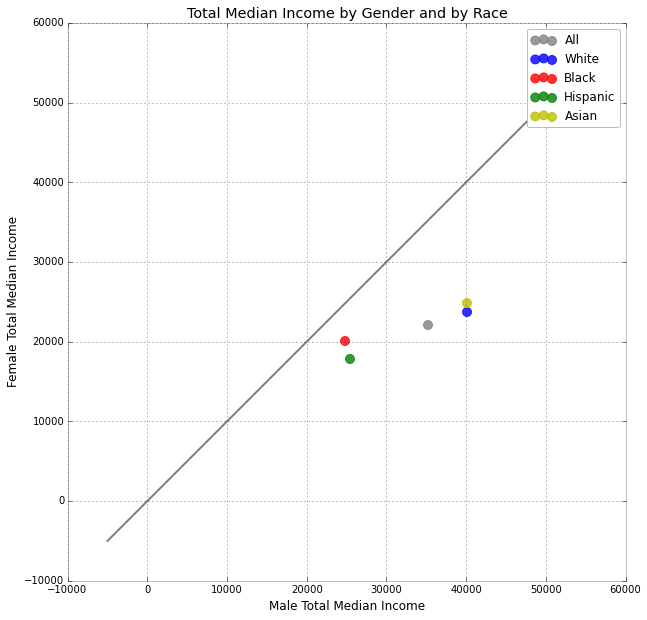

In [33]:
# Plot the Total Median Income of females vs the Total Median Income of males by race.
# TMI = Total Median Income.
# Create a 1-1 line.

pl.figure(figsize=(10,10))
xlabel('Male Total Median Income')
ylabel('Female Total Median Income')
pl.title("Total Median Income by Gender and by Race")

pl.scatter(male_median_all[1], female_median_all[1],alpha=.8, s=80,color = 'grey', label='All')
pl.scatter(male_median_white[1], female_median_white[1],alpha=.8, s=80,color = 'b', label='White')
pl.scatter(male_median_black[1], female_median_black[1],alpha=.8, s=80,color = 'r', label='Black')
pl.scatter(male_median_hispanic[1], female_median_hispanic[1],alpha=.8, s=80,color = 'g', label='Hispanic')
pl.scatter(male_median_asian[1], female_median_asian[1],alpha=.8, s=80,color = 'y', label='Asian')
pl.plt.legend()

plot([-5000, 50000], [-5000, 50000], color = 'black', alpha=.5)

#Now fit it with a line!
You can use statsmodels, or scipy, numpy, or create your own residual minimization function. 
If you want to use numpy (and you do not have to!) you can for example use 


pl.plot(newx,np.poly1d(np.ployfit(x,y,1))(newx)

to make and plot the fit in one line (although this way you did not save the parameters so you need to rerun the function to get the slope and intercept ... :-/

why not challenge yourself (if you want) and  create your own residual minimization function you can minimize it with scipy instead of a nested for loop (which is called 'brute force minimization')

from scipy.optimize import minimize

def line ().....
    #this would be a function that creates a line given parameters, like we did in class
    ...
    return y
def residuals(data, model, error=None):
    #you can add errors if you want
    you want to return the sum of the residuals (difference b/w data and model **2)
    return residuals

you need an initial guess for the parameters, where you start searching. it has to be a single variable, so for 2 parameters make a list of 2 elements. the numbers inside do not have to be 0 and 1 - but choose something not too crazy or your minimization will get lost!

p0 = [0,1] 

result = minimize(residuals, p0, args=(all_males, all_females))

in args i put all arguments of the function residuals that are not to be evaluated for the minimization (in this case the data)

In [37]:
## Now we want to build a regression model of total median income and fit this linear regression line on the plot.
male = [male_median_all[1], male_median_white[1], male_median_black[1], male_median_hispanic[1], male_median_asian[1]]
female = [female_median_all[1], female_median_white[1], female_median_black[1], female_median_hispanic[1], female_median_asian[1]]
mod = sm.OLS(female, male).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     395.4
Date:                Wed, 14 Oct 2015   Prob (F-statistic):           3.77e-05
Time:                        13:13:48   Log-Likelihood:                -45.545
No. Observations:                   5   AIC:                             93.09
Df Residuals:                       4   BIC:                             92.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.6423      0.032     19.885      0.0

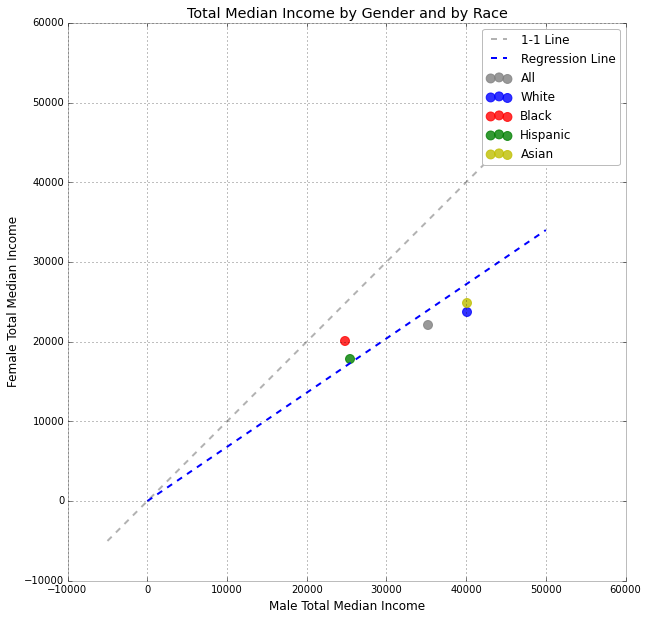

In [103]:
pl.figure(figsize=(10,10))
xlabel('Male Total Median Income')
ylabel('Female Total Median Income')
pl.title("Total Median Income by Gender and by Race")

pl.scatter(male_median_all[1], female_median_all[1],alpha=.8, s=80,color = 'grey', label='All')
pl.scatter(male_median_white[1], female_median_white[1],alpha=.8, s=80,color = 'b', label='White')
pl.scatter(male_median_black[1], female_median_black[1],alpha=.8, s=80,color = 'r', label='Black')
pl.scatter(male_median_hispanic[1], female_median_hispanic[1],alpha=.8, s=80,color = 'g', label='Hispanic')
pl.scatter(male_median_asian[1], female_median_asian[1],alpha=.8, s=80,color = 'y', label='Asian')


plot([-5000, 50000], [-5000, 50000], color = 'black',ls = '--', alpha=.3, label = '1-1 Line')

myseed = np.random.seed(50000)
x = np.arange (0,50000, 1)

def line (xx, a, b):
    return a*(xx) + b
lineB = line(x, 0.680, 0)
pl.plot (lineB, ls = '--', color = 'blue', label='Regression Line')
pl.plt.legend()

In [102]:
#from scipy.optimize import minimize

#def residuals(data, model, error=None):
    #return sum((data-model)**2)
#p0 = [0,1]
#result = minimize(residuals, p0, args=(male_median_all, female_median_all))


###There is an analytical solution for the OLS regression it is coded below. 

In [45]:
#This is the analytical best regression line. 
import scipy.stats as stats

cor = stats.spearmanr(male, female)
beta1=cor[0]*np.std(female)/np.std(male)
beta0=np.mean(female)-beta1*np.mean(male)

print beta1, beta0

0.338176888526 10485.9510732


##and plot the line corresponding to the analytical regression to compare it with the result of your numerical one

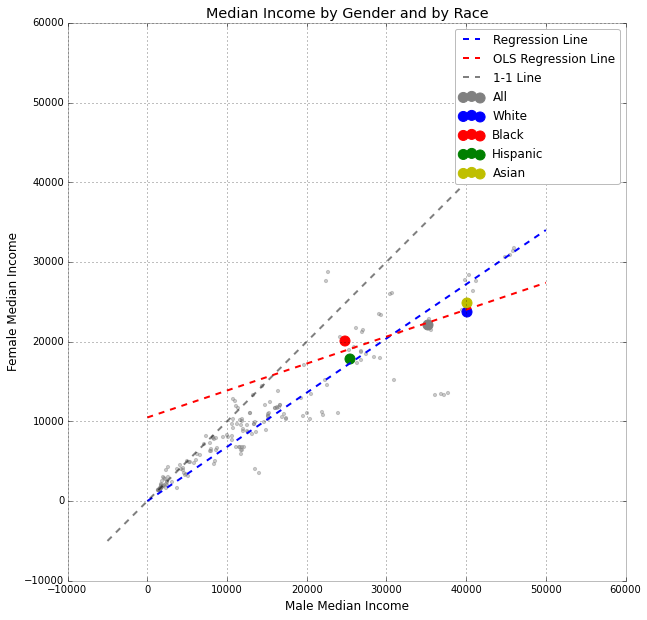

In [106]:
pl.figure(figsize=(10,10))

xlabel('Male Median Income')
ylabel('Female Median Income')
pl.title("Median Income by Gender and by Race")

pl.scatter(male_median_all, female_median_all,alpha=.4, s=10, color = 'grey')
pl.scatter(male_median_white, female_median_white,alpha=.4, s=10, color = 'grey')
pl.scatter(male_median_black, female_median_black,alpha=.4, s=10, color = 'grey')
pl.scatter(male_median_hispanic, female_median_hispanic,alpha=.4, s=10, color = 'grey')
pl.scatter(male_median_asian, female_median_asian,alpha=.4, s=10, color = 'grey')

pl.scatter(male_median_all[1], female_median_all[1],alpha=1, s=100,color = 'grey', label='All')
pl.scatter(male_median_white[1], female_median_white[1],alpha=1, s=100,color = 'b', label='White')
pl.scatter(male_median_black[1], female_median_black[1],alpha=1, s=100,color = 'r', label='Black')
pl.scatter(male_median_hispanic[1], female_median_hispanic[1],alpha=1, s=100,color = 'g', label='Hispanic')
pl.scatter(male_median_asian[1], female_median_asian[1],alpha=1, s=100,color = 'y', label='Asian')


myseed = np.random.seed(50000)
x = np.arange (0,50000, 1)

def line (xx, a, b):
    return a*(xx) + b
lineB = line(x, 0.680, 0)
lineC = line(x, beta1, beta0)

plot (lineB, color = 'b', ls='--', label='Regression Line')
plot (lineC, color = 'r', ls='--', label='OLS Regression Line')
plot([-5000, 50000], [-5000, 50000], color = 'black',ls = '--', alpha=.5, label = '1-1 Line')

pl.plt.legend()

This was done with __THE TOTAL MEDIAN INCOME__, let's now see if all forms of income lead to a different fit. 

If we use one data point for source of income (along the 'Median income' column) and fit a line and the line fit is similar then the median income was representative fo all forms of income for this analysis.

To unravel the data and concatenate them back together in a single array is a little complex.
Here are a few lines of code that should do the trick. I used __nu.concatenate__ to put together arrays (it takes a list of arrays) and __np.flatten__ to make the array 1 dimensional after merging. I also masked the __nan values__. I used the __numpy.ma__ (masled array) package. Every array is associated by this package to a mask array of Bools [True....False...] of the same size. 

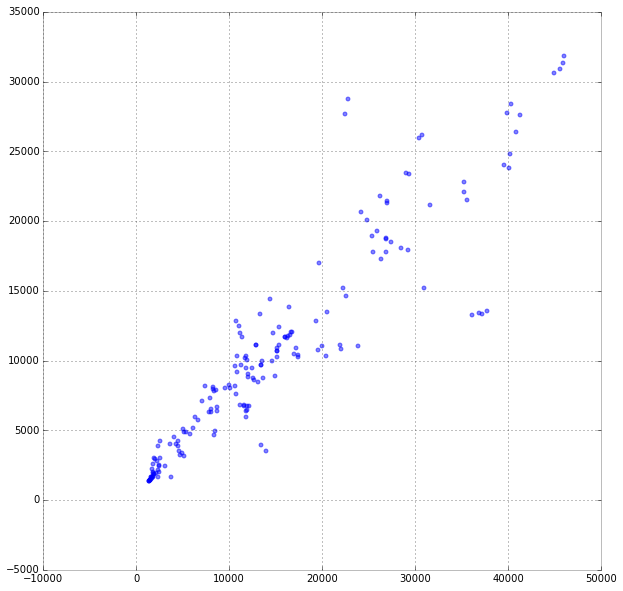

In [91]:
##Concatenate all median income by races.

all_males=np.ma.array(np.concatenate([allmales['all']['Median income'][:].values,allmales['white']['Median income'][:].values,allmales['black']['Median income'][:].values,allmales['hispanic']['Median income'][:].values,allmales['asian']['Median income'][:].values]).flatten())
all_females=np.ma.array(np.concatenate([allfemales['all']['Median income'][:].values,allfemales['white']['Median income'][:].values,allfemales['black']['Median income'][:].values,allfemales['hispanic']['Median income'][:].values,allfemales['asian']['Median income'][:].values]).flatten())

#I am gonna create the mask in the next line. 
#the mask is True where either male or female value is Nan. 
#Notice that True is really just >1, and False really 0. 
#so i can add the male and female mask and the resulting mask will be 
#False where both arrays are not Nan, and true otherwise. 

allmask = [np.isnan(all_males) + np.isnan(all_females)]

all_females.mask = allmask
all_males.mask = allmask

##Plot the data.
pl.figure(figsize=(10,10))
pl.scatter(all_males,all_females, alpha=.5, s=15,color = 'b')

In [92]:
#all_males
#all_males_1 = np.ndarray.flatten (all_males)
#all_males_1
#all_females_1 = np.ndarray.flatten (all_females)
#all_females_1

In [95]:
#Fit the masked data by using numpy.ma.polyfit.
mod = np.polyfit(~np.isnan(all_males), ~np.isnan(all_females), deg=1)
mod

array([ 0.84364534,  0.12903226])

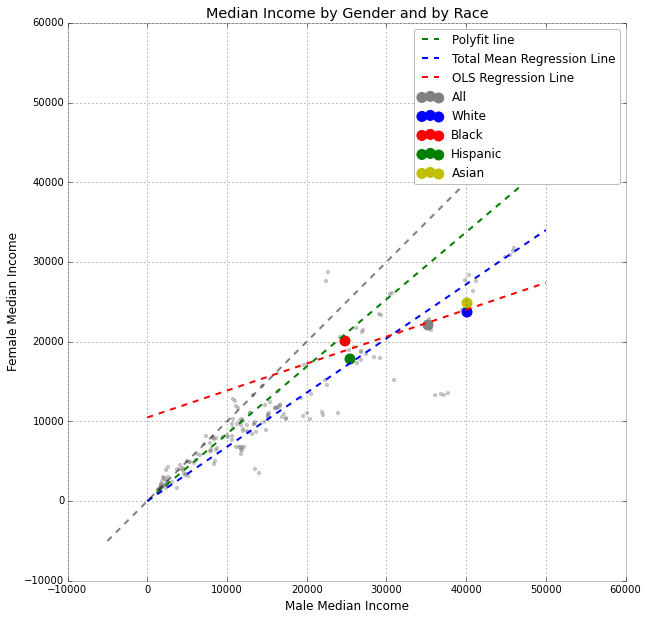

In [108]:
pl.figure(figsize=(10,10))

xlabel('Male Median Income')
ylabel('Female Median Income')
pl.title("Median Income by Gender and by Race")

pl.scatter(male_median_all, female_median_all,alpha=.4, s=10, color = 'grey')
pl.scatter(male_median_white, female_median_white,alpha=.4, s=10, color = 'grey')
pl.scatter(male_median_black, female_median_black,alpha=.4, s=10, color = 'grey')
pl.scatter(male_median_hispanic, female_median_hispanic,alpha=.4, s=10, color = 'grey')
pl.scatter(male_median_asian, female_median_asian,alpha=.4, s=10, color = 'grey')

pl.scatter(male_median_all[1], female_median_all[1],alpha=1, s=100,color = 'grey', label='All')
pl.scatter(male_median_white[1], female_median_white[1],alpha=1, s=100,color = 'b', label='White')
pl.scatter(male_median_black[1], female_median_black[1],alpha=1, s=100,color = 'r', label='Black')
pl.scatter(male_median_hispanic[1], female_median_hispanic[1],alpha=1, s=100,color = 'g', label='Hispanic')
pl.scatter(male_median_asian[1], female_median_asian[1],alpha=1, s=100,color = 'y', label='Asian')


myseed = np.random.seed(50000)
x = np.arange (0,50000, 1)

def line (xx, a, b):
    return a*(xx) + b
lineA = line(x,0.84364534,0.12903226 )
lineB = line(x, 0.680, 0)
lineC = line(x, beta1, beta0)

plot (lineA, color = 'g', ls='--', label = 'Polyfit line')
plot (lineB, color = 'b', ls='--', label = 'Total Mean Regression Line')
plot (lineC, color = 'r', ls='--', label = 'OLS Regression Line')
plot([-5000, 50000], [-5000, 50000], color = 'black',ls = '--', alpha=.5)
pl.plt.legend()


####Now pick a stipend, maybe your ideal stipend? 
####and predict what a woman in a position where a man recieves your ideal stipend would make

In [125]:
##Suppose the stipend is 10,000. 
##The woman will earn:
earn = 10000*0.84+0.13
print "If men earn 10,000, then women in same position will earn {}.".format(earn)

If men earn 10,000, then women in same position will earn 8400.13.


####Lastly do you have any comments about what these data tell us about race? how you would go about analyzing race differences with these data? (just a few sentences)

I found out White and Asian group are sharing similar median income, and there seems to be more equal income among male and female in Asian comparing White. 

First I would like to conduct a __t-test__ to check if difference having different average incomes. Then I would like to run a __logit regression model__ to see how race having impact on income. 

Also, I would love to plot the regression line by race so we could tell the gender equality difference by race.